# **CSCA 5622: Supervised Learning Final Project**

### Project Topic

This project focuses on classifying tweets from what was formerly known as Twitter (now called "X") using Natural Language Processing (NLP) techniques. The goal is to determine whether a tweet is referring to an actual disaster event (such as an earthquake, wildfire, flood, etc.) or not.

This is a supervised machine learning problem, with the specific task being binary classification. Each tweet will be categorized into one of two classes:

1. Disaster Related  
2. Not Disaster Related

Algorithms such as logistic regression can be used to accomplish this task.

---

### Project Goal

The main objective is to build a model that can accurately classify tweets during disasters, helping emergency services, and other organizations identify real-time information faster without having to manually sort through thousands of tweets.

Additionally, this project aims to:

- Explore the effectiveness of various NLP techniques on real-world classification problems.
- Understand the challenges of working with noisy text data typically found on social media platforms.


### Data

The dataset used in this project is sourced from a Kaggle competition titled **"Natural Language Processing with Disaster Tweets"**. It consists of approximately **10,000 tweets** that have been manually labeled to indicate whether they refer to a real disaster or not. 

The dataset is publicly available and can be accessed at the following link:

[https://www.kaggle.com/competitions/nlp-getting-started/data](https://www.kaggle.com/competitions/nlp-getting-started/data)

The data contains several useful fields, including:

- **Tweet Text**: The content of the tweet  
- **Keyword**: A disaster-related keyword extracted from the tweet (may be missing)  
- **Location**: The location associated with the tweet (may also be missing)

---

#### Citation (APA Style)

Kaggle. (n.d.). *Natural Language Processing with Disaster Tweets*.  
https://www.kaggle.com/competitions/nlp-getting-started/overview


In [1]:
#Importing the dataset into the notebook to begin working on it
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
#Importing modules need for this project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# **Data Pre-Cleaning and Cleaning**

### Initial Data Exploration (Pre-Cleaning)

The dataset used in this project is sourced from the Kaggle competition *“Natural Language Processing with Disaster Tweets.”* It consists of short text documents (tweets) that are labeled for binary classification: whether the tweet refers to a real disaster (`1`) or not (`0`). This characterizes the problem as a **supervised binary classification task using sequential text data**.

#### Training Data
- **Total rows (samples):** 7,613  
- **Total columns (features):** 5  

**Column Details:**
- `id` *(int64)*: Unique identifier for each tweet  
- `keyword` *(object)*: Disaster-related keyword (optional)  
- `location` *(object)*: User-defined location (optional)  
- `text` *(object)*: Main tweet content (primary feature)  
- `target` *(int64)*: Label — `1` for disaster-related, `0` otherwise  

#### Test Data
- **Total rows:** 3,263  
- **Columns:** Same as training data, excluding the `target` column  

#### Feature Summary
- The `text` column is the most critical feature and includes real-world language such as hashtags, links, abbreviations, and emojis.  
- The `keyword` column is populated in most cases (~99%) but contains some inconsistencies and duplications.  
- The `location` column is ~67% populated, with significant variation in content and format.  
- The `target` column represents a binary classification task.

#### Files in the Dataset
- `train.csv`: Labeled tweet data  
- `test.csv`: Unlabeled tweets for prediction  
- *(Note: `sample_submission.csv` is excluded from this analysis as it is used for Kaggle competition submission format only.)*

---

Below, the data is loaded and explored using Pandas, including its shape, column types, and a sample of the first few rows to better understand its structure.


In [3]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print('Train Shape:', train_df.shape)
print('Test Shape:', test_df.shape)
print('Train columns and data types:')
print(train_df.dtypes)
print('Train dataset info:')
train_df.info()
print('Head of training data')
print(train_df.head())

Train Shape: (7613, 5)
Test Shape: (3263, 4)
Train columns and data types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object
Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
Head of training data
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people rece

### Missing Data in `location` Column

The `location` column contained a large proportion of missing values, as well as inconsistently formatted entries. Many of the non-null values included user-generated content that lacked standardization, such as informal abbreviations, or vague place references. The bar chart below visualizes the imbalance between present and missing data. Due to this unreliability, the column was removed during preprocessing to avoid introducing noise into the model.


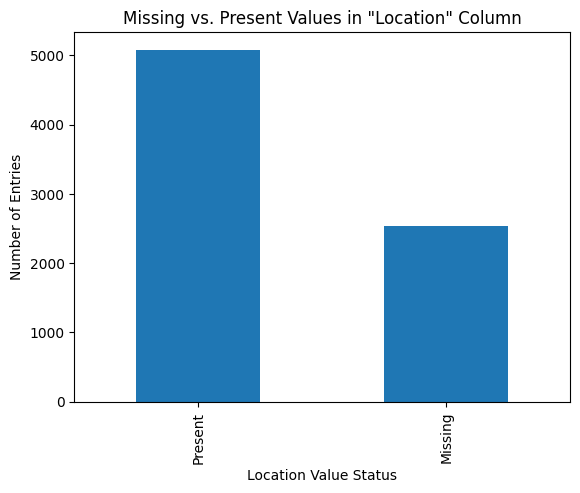

In [4]:
#Counting Present and Missing values in location column and then plotting
location_null_counts = train_df['location'].isnull().value_counts()
location_null_counts.index = ['Present', 'Missing']
location_null_counts.plot(kind='bar')
plt.title('Missing vs. Present Values in "Location" Column')
plt.xlabel('Location Value Status')
plt.ylabel('Number of Entries')
plt.show()

### Data Cleaning

Prior to modeling, the dataset was cleaned to reduce noise, handle inconsistencies, and make the data suitable for analysis. This section outlines the key preprocessing steps applied to the tweet text.

#### 1. Dropping the `location` Column

The `location` column contained a high proportion of missing values and inconsistent formats, such as city names, abbreviations, and user-written text. Due to its unreliability and the significant effort required for normalization, this column was excluded from the dataset.

#### 2. Removing Stopwords

Stopwords are common English words ("is", "in", "the", etc) that occur frequently but carry little contextual meaning. These were removed to reduce redundancy and improve the signal-to-noise ratio in the text data.

#### 3. Cleaning the Text

The `text` column serves as the main input feature for the classification task. Tweets often contain unstructured and noisy content, which was addressed by applying the following cleaning steps:

- Convert all text to lowercase for consistency  
- Remove URLs and HTML tags  
- Remove user mentions (`@username`)  
- Remove the `#` symbol while retaining the hashtag content  
- Remove punctuation and numeric characters  
- Tokenize the text and filter out stopwords  

These steps helped to standardize the data while preserving core content related to disaster relevance.

After processing, a new column named `clean_text` was created to store the cleaned version of each tweet. This column will be used in downstream analysis and modeling tasks.


In [5]:
#Drop 'Location' column
train_df.drop(columns=['location'], inplace=True)

#Create a list of english stopwords using the NLTK list
stop_words = list(stopwords.words('english'))

#Function to clean the text
def clean_text(text):
    #Lowercase
    text = text.lower()
    #Remove URL's
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    #Remote HTML tags
    text = re.sub(r'<.*?>', '', text)
    #Remove mentions 
    text = re.sub(r'@\w+', '', text)
    #Remove hashtag symbol while mainting the actual hashtag text
    text = re.sub(r'#', '', text)
    #Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)    

train_df['clean_text'] = train_df['text'].apply(clean_text)

### Refining the Cleaned Text

After the initial pass at cleaning the tweet text, results were reviewed using before-and-after word clouds. While the cleaning process significantly reduced noise, several uninformative tokens such as `"amp"`, `"via"`, `"rt"`, and `"co"` continued to appear frequently in the cleaned text.

An issue was identified in the handling of stopwords containing apostrophes (such as `"don't"`, `"can't"`, `"you're"`), which were not being removed. This occurred because the punctuation removal step eliminates apostrophes, resulting in tokens like `"dont"` and `"cant"` that are not included in the standard NLTK stopwords list.

To improve the preprocessing:
- A **custom stopwords list** was introduced to capture dataset-specific and modified terms (such as `"amp"`, `"rt"`, `"dont"`, `"cant"`).
- **Short words** (less than 3 characters) were removed, as these often represent abbreviations or filler words that do not contribute meaningful information.

These refinements help eliminate residual noise and further prepare the text for reliable modeling and analysis.


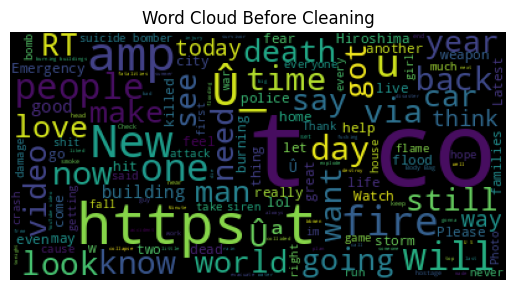

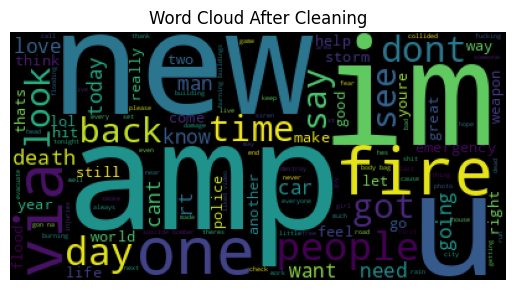

In [6]:
#Creating and plotting wordclouds for the clean and raw text
text_cleaned = ' '.join(train_df['clean_text'])
text_raw = ' '.join(train_df['text'])
wordcloud_raw = WordCloud().generate(text_raw)
plt.imshow(wordcloud_raw)
plt.axis('off')
plt.title('Word Cloud Before Cleaning')
plt.show()
wordcloud_cleaned = WordCloud().generate(text_cleaned)
plt.imshow(wordcloud_cleaned)
plt.axis('off')
plt.title('Word Cloud After Cleaning')
plt.show()

### Word Cloud After Final Cleaning

The word cloud below illustrates the most frequent words in the tweet dataset after applying the final text preprocessing steps. Compared to the earlier versions, most of the irrelevant tokens such as `"amp"`, `"rt"`, `"co"`, and other social media artifacts have been successfully removed.

This final version of the `clean_text` column was produced by:
- Removing standard and custom stopwords, including modified forms without apostrophes (`"dont"`, `"cant"`, `"youre", etc`)
- Eliminating short, non-informative tokens (less than 3 characters)
- Removing punctuation, URLs, mentions, and HTML tags

The resulting visualization highlights more meaningful and contextually relevant terms such as `"fire"`, `"death"`, `"emergency"`, `"people"`, and `"help"` , all of which are strongly aligned with the task of identifying disaster-related tweets.

This refined version of the text will now serve as the foundation for feature extraction and model training.


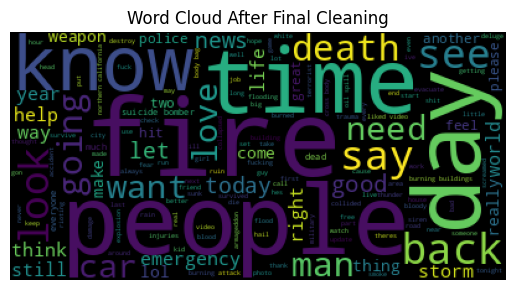

In [7]:
#Exanding stopwords list to further reduce noise
custom_stopwords = [
    'amp', 'rt', 'new', 'one', 'via', 'u', 'im', 'dont', 'got', 't', 'co',
    'cant', 'wont', 'doesnt', 'isnt', 'wasnt', 'wouldnt', 'shouldnt',
    'couldnt', 'arent', 'didnt', 'havent', 'hasnt', 'youre', 'theyre', 'thats'
]
stop_words += custom_stopwords

#Updated cleaning function
def clean_text_final(text):
    #Lowercase
    text = text.lower()
    #Remove URL's
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    #Remote HTML tags
    text = re.sub(r'<.*?>', '', text)
    #Remove mentions 
    text = re.sub(r'@\w+', '', text)
    #Remove hashtag symbol while mainting the actual hashtag text
    text = re.sub(r'#', '', text)
    #Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

#Applying to dataset 
train_df['clean_text'] = train_df['text'].apply(clean_text_final)

#Plotting updated wordcloud
text_cleaned = ' '.join(train_df['clean_text'])
wordcloud_cleaned = WordCloud().generate(text_cleaned)
plt.imshow(wordcloud_cleaned)
plt.axis('off')
plt.title('Word Cloud After Final Cleaning')
plt.show()

# **Exploratory Data Analysis**

### Target Class Distribution

The bar chart below shows the distribution of tweets labeled as disaster-related (`1`) versus non-disaster-related (`0`). This helps assess whether the dataset is balanced or imbalanced.

A relatively balanced distribution was observed, though non-disaster tweets are slightly more frequent. This is useful to know for model training, as significant imbalance could bias the classifier toward the majority class. 


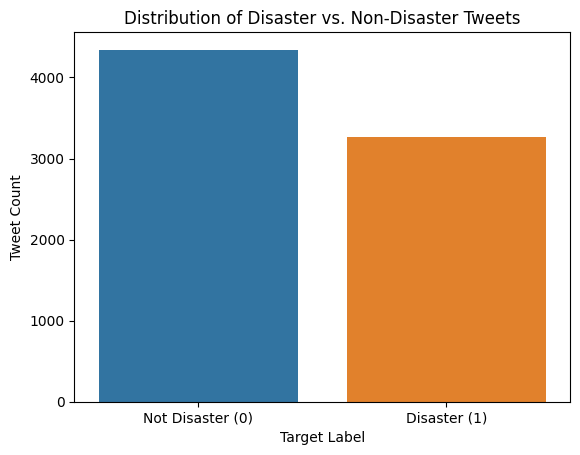

In [8]:
#Plot distribution of disaster vs non disaster tweets
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster vs. Non-Disaster Tweets')
plt.xlabel('Target Label')
plt.ylabel('Tweet Count')
plt.xticks([0,1],['Not Disaster (0)', 'Disaster (1)'])
plt.show()

### Tweet Length Distribution

The histogram below displays the distribution of tweet lengths in the dataset, measured by the number of characters in each tweet. A significant portion of tweets are between **100 and 140 characters**, with a notable peak near the **140-character limit**, reflecting Twitter’s historical character constraint prior to its expansion to 280 characters.

This insight suggests that many users tend to utilize the full available space when posting tweets, particularly when conveying detailed or urgent information. This is relevant for disaster-related content, which may require more context or description.

Only a small number of tweets fall below 40 characters or exceed 140 characters. 


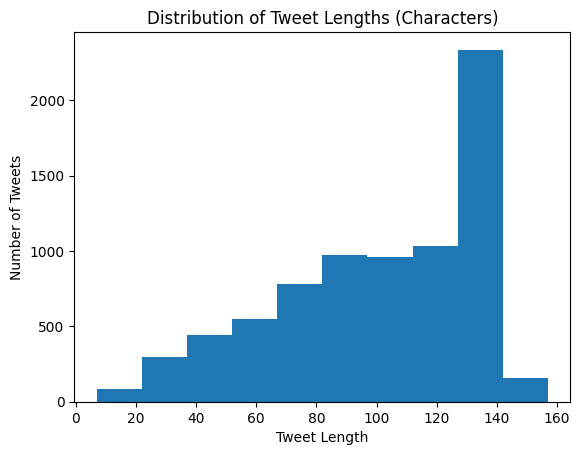

In [9]:
#Plot length of tweets
train_df['text_length'] = train_df['text'].apply(len)
plt.hist(train_df['text_length'])
plt.title('Distribution of Tweet Lengths (Characters)')
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.show()

### Top Keywords in the Dataset

The bar chart below shows the top 20 most frequently occurring keywords in the dataset. These keywords are manually assigned and represent high-level disaster topics such as `"fatalities"`, , and `"damage"`.

This distribution reveals the most common types of disaster-related content represented in the dataset. For example, keywords like `"outbreak"` suggest a variety of incident types including natural disasters, public health events, and human-made accidents.

While the `keyword` column is present in most rows and appears to provide useful categorical information, it also contains inconsistencies. For example, the keyword `"body%20bags"` appears in its URL-encoded form rather than as `"body bags"`, indicating a lack of normalization in the source data. 

Such inconsistencies could reduce the effectiveness of this column as a predictive feature. Without cleaning and standardization, the `keyword` values may introduce noise rather than signal. As a result, this column may not be suitable for modeling in its current state and should either be cleaned or excluded from feature selection.


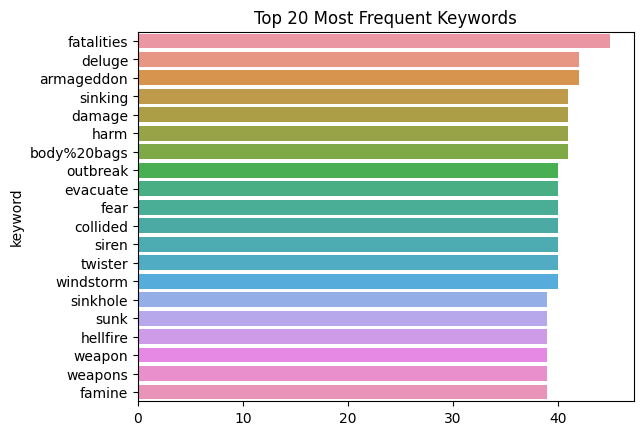

In [10]:
#Plot top 20 keywords
top_keywords = train_df['keyword'].value_counts().nlargest(20)
sns.barplot(x=top_keywords.values, y=top_keywords.index)
plt.title('Top 20 Most Frequent Keywords')
plt.show()

### Correlation Matrix of Numeric Features

The heatmap below shows the correlation between several engineered numeric features in the dataset:

- `has_keyword`: a binary variable indicating whether a keyword is present
- `text_length`: the character length of each tweet
- `target`: the binary classification label (1 for disaster, 0 for non-disaster)

The correlation matrix reveals that there are **no strong linear relationships** between these features. This indicates that simple numeric variables like tweet length and keyword presence are not strongly predictive of the target label on their own.

While these features may still provide value when combined with textual data or used in non-linear models, the correlation results support focusing primarily on the content of the tweets as the primary signal for classification.


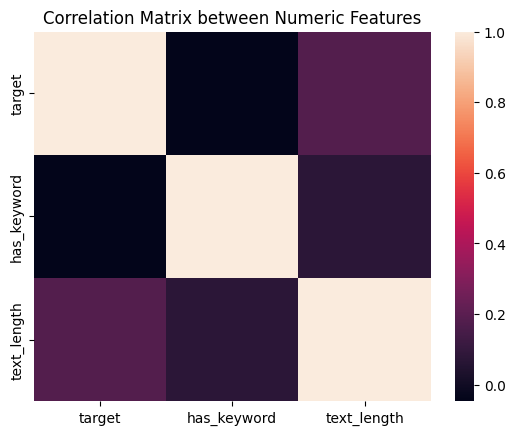

In [11]:
#Create correlation matrix
train_df['has_keyword'] = train_df['keyword'].notnull().astype(int)
train_df['text_length'] = train_df['text'].apply(len)
correlation = train_df[['target', 'has_keyword', 'text_length']].corr()
sns.heatmap(correlation)
plt.title('Correlation Matrix between Numeric Features')
plt.show()

### Statistical Test Tweet Length by Target

To evaluate whether tweet lengths differ significantly between disaster-related and non-disaster tweets, a two-sample independent t-test was performed.

- **T-statistic:** 16.13  
- **P-value:** < 0.0001

Since the p-value is far below the typical significance threshold of 0.05, the difference in average tweet lengths is considered **statistically significant**. This indicates that tweet length may be a useful supporting feature when distinguishing between the two classes.

The result supports the inclusion of tweet length as a numerical feature in future modeling steps, alongside textual data extracted from the tweet content.


In [12]:
#Statistical Test is performed
length_disaster = train_df[train_df['target'] == 1]['text_length']
length_non_disaster = train_df[train_df['target'] == 0]['text_length']
t_stat, p_val = ttest_ind(length_disaster, length_non_disaster)
print(f"T-statistic Raw: {t_stat}")
print(f"P-value Raw: {p_val}")
print(f'T-statistic Rounded: {t_stat:.2f}')
print(f'P-value Rounded: {p_val:.4f}')

T-statistic Raw: 16.1307521158452
P-value Raw: 1.3877794434473213e-57
T-statistic Rounded: 16.13
P-value Rounded: 0.0000


# **Modeling**

### Baseline Logistic Regression Model 

The first supervised model implemented was a **Logistic Regression classifier**, using only the created numeric features:

- `text_length`: the number of characters in the tweet
- `has_keyword`: a binary indicator of whether a keyword was present

These features were selected based on earlier exploratory data analysis, where tweet length was found to differ significantly between the two target classes, and keyword presence provided some (though very limited) signal.

Before training, the features were standardized using `StandardScaler` to ensure fair weighting across features. 

The data was split into training and test sets using an 80/20 split, and the model was trained with default hyperparameters using scikit-learn’s `LogisticRegression` class.


In [13]:
#Generate X and Y
X = train_df[['text_length', 'has_keyword']]
y = train_df['target']

#Standardize the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

### Logistic Regression Classifier

The classification report below summarizes the baseline model’s performance on the test set.

- The model performs moderately well in identifying non-disaster tweets (`class 0`), achieving a precision of 0.62 and recall of 0.73.
- However, it struggles to identify disaster-related tweets (`class 1`), with lower precision (0.50) and recall (0.38).
- The overall accuracy is 0.58.

This result suggests that numeric features alone are insufficient for high-performance classification.

Nonetheless, this model establishes a performance baseline and confirms that tweet length and keyword presence do carry some predictive information, even without analyzing the full tweet text.


In [14]:
#Create Logistic Regression Model and print classification report
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.73      0.67       884
           1       0.50      0.38      0.43       639

    accuracy                           0.58      1523
   macro avg       0.56      0.55      0.55      1523
weighted avg       0.57      0.58      0.57      1523



### Random Forest Classifier

A **Random Forest Classifier** was trained using the same features as before: `text_length` and `has_keyword`. Random Forest is a type of model that builds many decision trees and combines their results to make a final prediction. It works well with non-linear data and doesn’t require feature scaling.

### Results

- **Accuracy:** 0.62  
- **F1-score (non-disaster):** 0.70  
- **F1-score (disaster):** 0.48  
- **Macro average F1-score:** 0.59

The model did a better job than logistic regression, especially in terms of overall accuracy and balance between the two classes. It was still more accurate with non-disaster tweets, but slightly improved at detecting disaster-related tweets compared to the first model.

This shows that Random Forest can find more patterns in the data, even with just a couple of simple features.


In [15]:
#Create Random Forest Model and print classification report
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.63      0.75      0.68       884
           1       0.52      0.38      0.44       639

    accuracy                           0.59      1523
   macro avg       0.57      0.57      0.56      1523
weighted avg       0.58      0.59      0.58      1523



### Hyperparameter Tuning Random Forest with GridSearchCV

To improve performance, `GridSearchCV` was used to tune the Random Forest hyperparameters using 3-fold cross-validation. The model was optimized for F1-score, with the best configuration found to be:

- `n_estimators=150`
- `max_depth=10`
- `min_samples_split=2`
- `class_weight='balanced'`

When evaluated on the test set, the tuned model showed a slight trade-off:
- It performed **better at identifying disaster tweets** (F1-score increased from 0.48 to 0.53)
- But slightly worse at predicting non-disaster tweets, reducing overall accuracy from 0.62 to 0.57

This result highlights how tuning can help prioritize the model’s focus (in this case, improving the minority class), even if it doesn't always improve all metrics across the board.


In [16]:
#Create a parameter grid for Random Forest and run it through GridSearchCV to determine best parameter combo
param_grid = {
    'n_estimators': [100,150,200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}
grid_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1')
grid_rf.fit(X_train, y_train)

print("Best Parameters:", grid_rf.best_params_)
print("Best F1 Score:", grid_rf.best_score_)

y_pred_best = grid_rf.predict(X_test)
print(classification_report(y_test, y_pred_best))

Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score: 0.542525273424717
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       884
           1       0.49      0.53      0.51       639

    accuracy                           0.57      1523
   macro avg       0.56      0.56      0.56      1523
weighted avg       0.57      0.57      0.57      1523



### Text-Based Classification Using TF-IDF and Logistic Regression

In this model, the cleaned tweet text (`clean_text`) was used as the primary input. The text was converted into numerical features using **TF-IDF (Term Frequency–Inverse Document Frequency)**, which highlights the most important words in each tweet based on how frequently they appear relative to other tweets.

A **Logistic Regression** model was trained using these features to classify tweets as disaster-related or not. No additional features or class weighting was used.

#### Results:

- **Accuracy:** 0.81
- **F1-score (Disaster class):** 0.74
- **F1-score (Non-disaster class):** 0.85
- **Macro average F1-score:** 0.80

Compared to previous models that relied on numerical features like tweet length, this model performed significantly better. The improvement demonstrates how important it is to analyze the actual language in the tweets, rather than just numerical data. It also highlights the effectiveness of TF-IDF for text classification tasks.


In [17]:
#Create TF-IDF features from the clean text column
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(train_df['clean_text'])
y = train_df['target']
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2)

#Train model,predict, and evaluate
lr_text_model = LogisticRegression(max_iter=1000)
lr_text_model.fit(X_train_text, y_train)
y_pred_text = lr_text_model.predict(X_test_text)
print(classification_report(y_test, y_pred_text))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       860
           1       0.84      0.66      0.74       663

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.79      1523



### Addressing Multicollinearity in Models

Multicollinearity occurs when two or more input features are highly correlated, which can affect the stability and interpretability of models like Logistic Regression.

In this project, steps were taken to avoid multicollinearity:

- When using numeric features (`text_length`, `has_keyword`), only independent, non-correlated variables were selected. These features were also standardized to ensure they contributed evenly to the model.
- For text-based features, TF-IDF vectorization was used. This naturally downweights overly common words, and the resulting feature matrix is sparse, which reduces the risk of multicollinearity.
- Random Forest was also used, which is inherently robust to multicollinearity due to its tree-based nature.

By carefully selecting and engineering features, the project minimizes multicollinearity and ensures that models remain stable and interpretable.


# **Results and Analysis**


Several supervised models were trained and evaluated using different feature sets and techniques. Below is a summary of their performance:

| Model                         | Accuracy | F1 (Disaster) | F1 (Non-Disaster) | Macro Avg F1 |
|------------------------------|----------|---------------|-------------------|--------------|
| Logistic Regression (numeric only) | 0.58     | 0.43          | 0.67              | 0.55         |
| Random Forest (numeric only)       | 0.62     | 0.48          | 0.70              | 0.59         |
| Tuned Random Forest (numeric)      | 0.57     | 0.53          | 0.60              | 0.57         |
| **TF-IDF + Logistic Regression**   | **0.81** | **0.74**      | **0.85**          | **0.80**     |

The TF-IDF model significantly outperformed the numeric-only models. By using the actual tweet text, it was able to learn meaningful patterns that correlate with disaster-related content. 

### Evaluation Metrics

The **F1-score** was used to evaluate how well the model balances **precision** and **recall**, especially for the disaster class, which is slightly underrepresented.

The final model achieved:
- **F1-score (Disaster class):** 0.74

These results show the value of using text features and explain why advanced feature engineering and vectorization methods are important in NLP tasks.

### Iteration and Improvement

Throughout the project, models were improved by:
- Adding engineered numeric features (`text_length`, `has_keyword`)
- Tuning hyperparameters using `GridSearchCV`
- Switching to TF-IDF vectorization for richer feature representation
- Comparing results side-by-side to measure real progress

This iterative process helped identify the best modeling approach and led to a strong final result.



# **Discussion and Conclusion**


This project focused on classifying tweets as disaster-related or not using natural language processing and supervised machine learning models. Several approaches were explored, including numeric-only features, text-based features, and model tuning. Along the way, several valuable lessons and insights emerged.

#### Key Takeaways

One of the biggest takeaways was the importance of leveraging the actual text content in the tweets. Models that only used metadata (text length, presence of keywords) performed modestly, with accuracy around 60%. However, once the tweet text was transformed using TF-IDF and used as the main feature, model performance significantly improved, achieving an accuracy of 81% and an F1-score of 0.75 for the disaster class. This clearly shows that the language used in a tweet carries much more signal than metadata alone.

Additionally, iterating through multiple models (Logistic Regression and Random Forest), applying hyperparameter tuning, and testing evaluation metrics such as F1-score (instead of relying on accuracy alone) helped shape a more informed, balanced classification approach.

#### What Didn’t Work as Expected

While tuning Random Forest using `GridSearchCV` helped optimize performance for the disaster class, the overall results were slightly worse than the default Random Forest model. This was surprising and reinforced the fact that more tuning doesn’t always guarantee better real-world performance. Another limitation was the keyword column, which turned out to be noisy and inconsistent. Even though it appeared promising during initial EDA, it offered little value to the model in practice.

#### Opportunities for Future Improvement

Future improvements could include using more advanced NLP techniques. Additional text preprocessing (like misspellings) could further reduce noise. Lastly, integrating real-time or geo-tagged data could add valuable signals that improve model responsiveness during live disaster monitoring.

Overall, this project demonstrated the power of natural language understanding in emergency communication and the importance of combining feature engineering with model evaluation to build effective and reliable classifiers.
